# 08. PyTorch Paper Replicating

Replicating [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
](https://arxiv.org/abs/2010.11929): Vision Transformers.

## 0. Setup

In [41]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

In [43]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [44]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders


### 2.1 Prepare transforms for images

In [45]:
# Create image size (from table 3 in ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into DataLoaders

The ViT paper mentions a batch size of 4096, meaning 4096 images need to fit in the GPU memory at a time. Google Colab free tier GPUs cannot handle this so we will lower the batch size.

**NOTE:** `pin_memory=True` avoids unnecessary copying of memory between CPU and GPU by 'pinning' the content (not letting it move to CPU).

In [46]:
BATCH_SIZE = 32                 # Depends on the hardware

# Creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2198e2851b0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [47]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shape
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

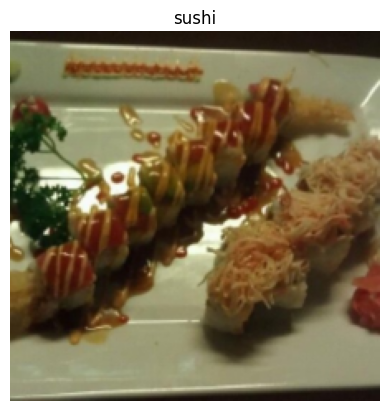

In [48]:
plt.imshow(image.permute(1, 2, 0))          # Rearrange the dimensions to (C, H, W)
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and outputs, layers and blocks

* **Layer:** Takes an input, performs a function on it and returns the output
* **Block:** A collection of layers, takes an input, performs a series of functions on it and returns an output.
* **Architecture (or model)**: A collection of blocks, takes an input, performs a series of functions on it, and returns an output.

### 3.2 Getting specific: What's ViT is made of?

We'll focus on
1. The model architecture

2. 4 equations in section 3.1

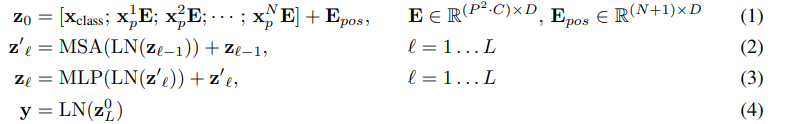

3. Table 1 (the ViT Base model):

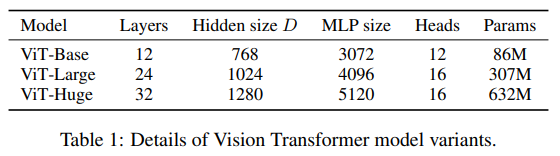

### 3.2.1 Exploring the model architecture
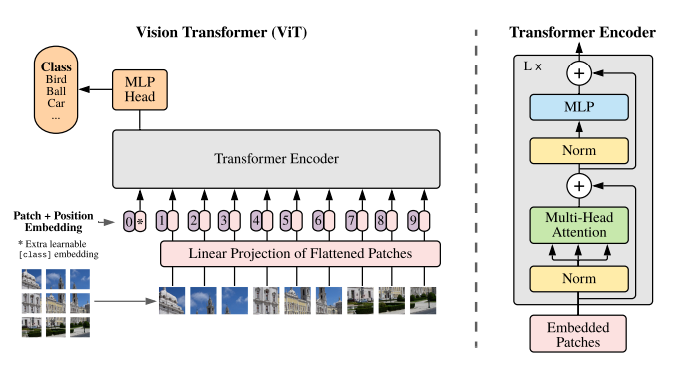

The ViT architecure is comprised of several stages:
* **Patch + Position Embeddings (inputs):** Turns the image into sequence of patches & adds a position number to identify the order in which the patches come in.
* **Linear projection of flattened patches (Embedded patches):** The image patches get turned into embeddings. The benefit of using embeddings is that it is a learnable representation of the image (usually in the form of a vector) and can improve with training, which is not possible if we directly use the image values.
* **Layer Normalization (Norm):** It is a technique for regularizing a neural network, can be implemented in PyTorch using `torch.nn.LayerNorm()`.
* **Multi-Head Attention:** A multi-head self-attention layer, used to run an attention mechanism several times in parallel.
* **Multi-layer perceptron (MLP):** A multi-layered feedforward neural network. In the ViT paper, the authors use 2 linear layers with GeLU activation function and a dropout layer after each linear layer for regularization.
* **Transformer Encoder:** The collection of all the layers listed above form the Transformer Encoder. The ViT architecture comprises of a number of Encoder layers stacked on top of each other. There are 2 skip connections in the Encoder layer denoted by '+' symbols. Skip connections mean directly feeding the input to an immediate layer/layers as well as the next layer.
* **MLP Head:** This is the output layer, it converts the learned features of an input to a class output. We can also call it the classifier head.

### 3.2.2 Exploring the 4 equations
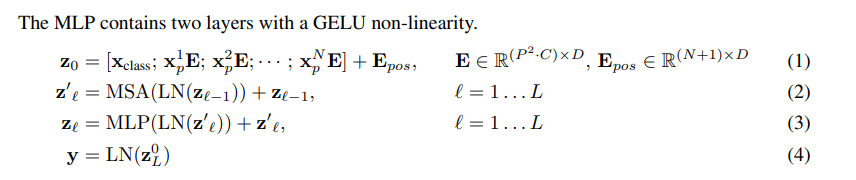

**Equation 1:**
The transformer uses constant latent vector size `D` through all of its layers, so we flatten the patches and map to `D` dimensions with a trainable linear projection (Eqn 1). We refer to the output of this projection as the patch embeddings. Position embeddings are added to the patch embeddings to retain positional information as in images, the position also matters. We use standard learnable 1D position embeddings.

In vector form, the embedding may look like:
`x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]`, here each element in the vector is learnable.

**Equation 2 and 3:**
The transformer encoder uses alternating layers of multi-head self attention (MSA) and MLP blocks. Layer Normalization (LN) is applied before every block and residual connections (skip connections) after every block.

We'll call the layer in equation 2 as MSA block, which looks something like this:
`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`

We'll call the layer in equation 3 as MLP block, which looks something like this:
`x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block`

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$. Basically, it is the classification layer used for classifying, e.g. if it's a pizza, steak or sushi.

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN). In our case, it may look something like this:
`y = Linear_layer(LN_layer(x_output_MLP_block[0]))`


### 3.2.7 Exploring Table 1
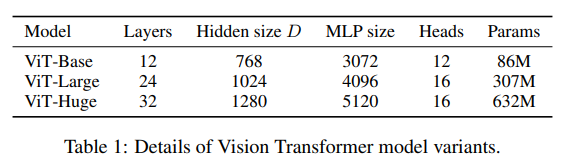

Breaking down the hyperparameters
* **Layers:** The number of transformer encoder blocks, each with a MSA and a MLP block.
* **Hidden Size `D`:** This is the size of the vector that our image gets converted into (embedding dimension). Bigger embedding dimension = more info captured = better results, but it also means more compute.
* **MLP Size:** Number of hidden units in each MLP layer.
* **Heads:** Number of heads in multi-headed attention layers
* **Params:** Total number of parameters in the model.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding


Remember, an embedding is a learnable representation of some form, usually a vector.

`Image -> patches -> patch embeddings`

Let's go through the opening paragraph of section 3.1 of the paper
> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Let's break it down:
* Size of patch embeddings: $D$
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.

* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (patch size).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

### 4.1 Calculating patch embedding input and output shapes by hand

We'll use a patch size $P$ of 16 since the best performing version of ViT-Base uses it (Table 5)

In [49]:
height, width = 224, 224            # Training resolution is 224 as per the paper
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / (patch_size ** 2))       # N
print(f"Number of patches (N): {number_of_patches}\nWith image height (H={height}), weight (W={width}) and patch size (P={patch_size})")

Number of patches (N): 196
With image height (H=224), weight (W=224) and patch size (P=16)


**Creating the input & output shapes of the patch embedding layer:**

Input: The image starts as 2D with size ${H \times W \times C}$.
Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [50]:
# Input shape (size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape (size of patches)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (Single Image): {embedding_layer_input_shape}")
print(f"Output shape (Single image flattened into 2D patches): {embedding_layer_output_shape}")

Input shape (Single Image): (224, 224, 3)
Output shape (Single image flattened into 2D patches): (196, 768)


### 4.2 Turning a single image into patches
Now we know the ideal input and output shapes for our patch embedding layer, let's move towards making it.

(-0.5, 223.5, 223.5, -0.5)

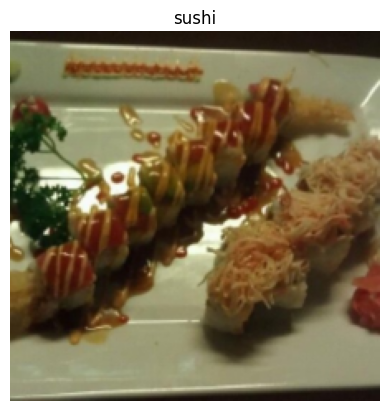

In [51]:
# Viewing a sample image
image_permuted = image.permute(1, 2, 0)     # For matplotlib
plt.imshow(image_permuted)      
plt.title(class_names[label])
plt.axis(False)

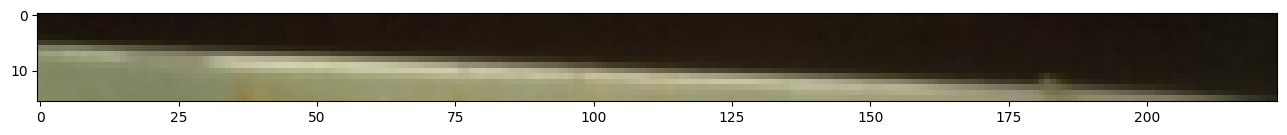

In [52]:
# Viewing the top row of the patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size:])

Now let's convert it into patches

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


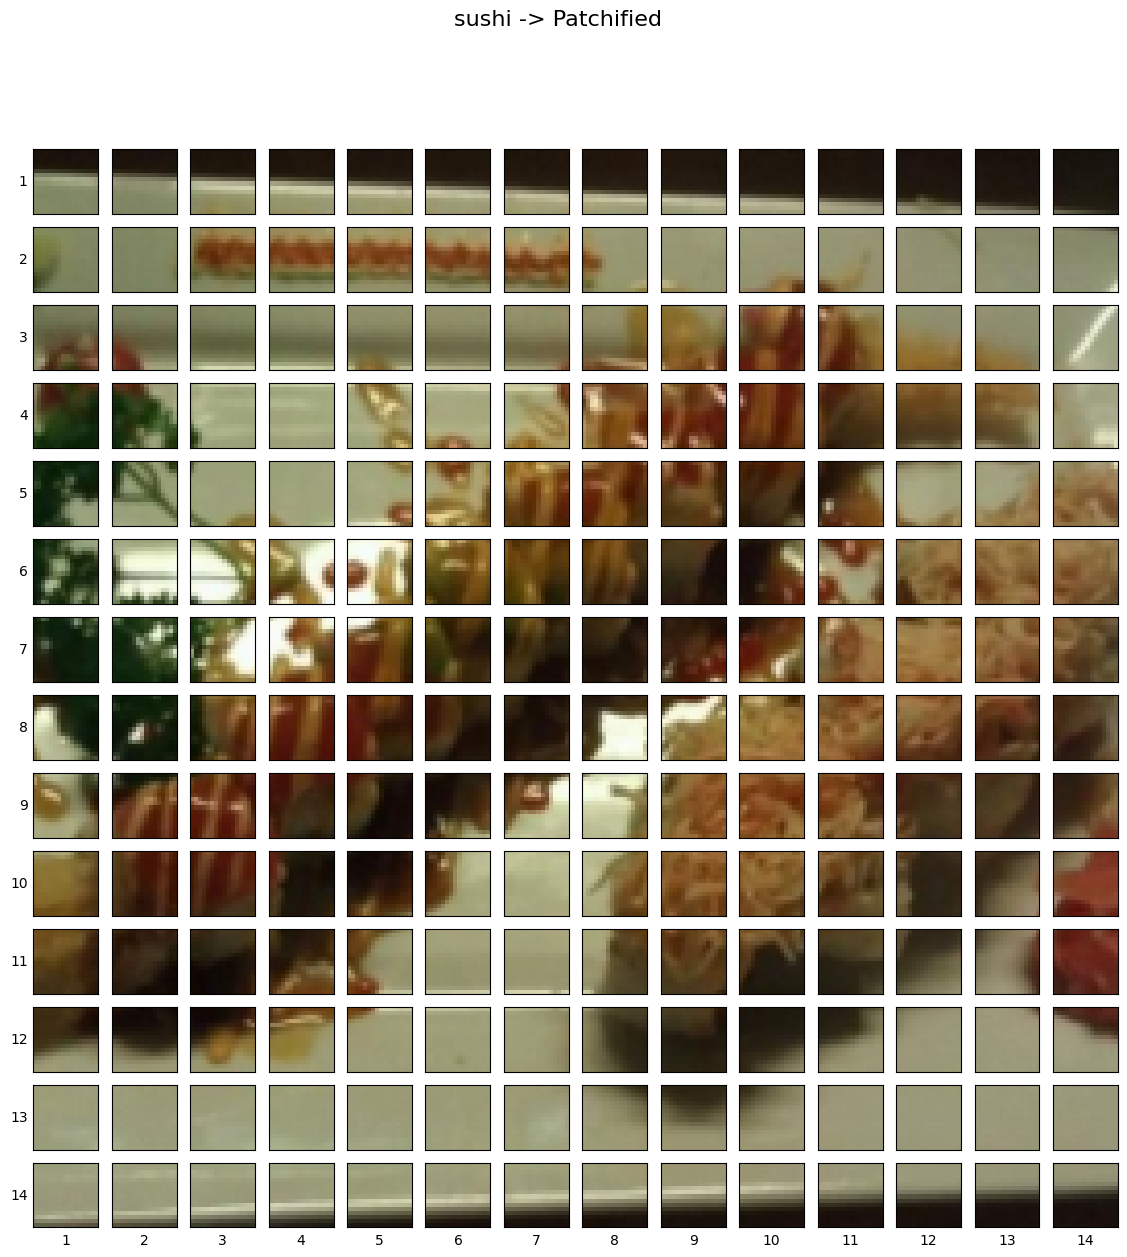

In [55]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()
